In [ ]:
!pip install xlrd

In [ ]:
!pip install openpyxl

import pathlib

import pandas as pd
import numpy as np
import xlrd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import scipy.stats as stats
import tensorflow as tf

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install bayesian-optimization

In [ ]:
PY_DATOS_REALES_EST_SA=pd.read_excel("/content/drive/MyDrive/Datos/Copia de 4 Variables. Datos reales estandarizados sin atípicos (z-score).xlsx", sheet_name='Datos sin atipicos', header=0, index_col=0, usecols='A, B, C, D, E')
PY_DATOS_REALES_EST_SA

Días      Área  PY_VC_PCA  Valor_Proyecto
#                                                 
1    0.199969 -0.224328  -0.670771       -0.563421
2    0.199969 -0.224328  -0.670771       -0.545120
3    0.199969 -0.222966  -0.670771       -0.544601
4    0.199969 -0.222966  -0.670771       -0.532932
5    1.478731 -0.182279  -0.670771       -0.532623
..        ...       ...        ...             ...
121 -0.699160 -0.219754  -1.883419       -0.617652
122 -0.659199 -0.223679  -1.883419       -0.604545
123 -0.579276 -0.224410  -1.883419       -0.584883
124 -0.898967 -0.074911  -1.932311       -0.488695
125  0.080085 -0.203695  -0.670771        1.333930

[115 rows x 4 columns]

In [ ]:
PY_DATOS_REALES_EST_SA.describe()

Días        Área   PY_VC_PCA  Valor_Proyecto
count  115.000000  115.000000  115.000000      115.000000
mean    -0.082193   -0.098454   -0.089025       -0.097465
std      0.780387    0.605987    1.861373        0.706249
min     -0.918948   -0.224417   -1.932311       -0.682176
25%     -0.669189   -0.224096   -1.883419       -0.587202
50%     -0.359489   -0.222363   -0.670771       -0.410561
75%      0.219950   -0.203633    0.739387        0.150954
max      3.576699    4.300396    3.524117        2.571424

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, ReLU, ELU
from keras.optimizers import Adam, RMSprop, SGD, Adadelta, Adagrad
from keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from bayes_opt import BayesianOptimization
from scipy.stats import spearmanr
import random

# Fijar la semilla para reproducibilidad
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Función personalizada para calcular SSE
def sse(y_true, y_pred):
    return tf.reduce_sum(tf.square(y_true - y_pred))

# Función personalizada para calcular SAE
def sae(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true - y_pred))

# Función personalizada para calcular el coeficiente de determinación R^2
def r2_keras(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

# Función personalizada para calcular el coeficiente de correlación de Pearson
def pearson_correlation(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    x = y_true - tf.reduce_mean(y_true)
    y = y_pred - tf.reduce_mean(y_pred)
    r_num = tf.reduce_sum(x * y)
    r_den = tf.sqrt(tf.reduce_sum(tf.square(x)) * tf.reduce_sum(tf.square(y)))
    return r_num / (r_den + tf.keras.backend.epsilon())

# Función para calcular RMSE
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Seleccionar las columnas relevantes para la predicción de 'Valor_Proyecto'
data = PY_DATOS_REALES_EST_SA[['Días', 'Área', 'PY_VC_PCA', 'Valor_Proyecto']]
X = data.drop('Valor_Proyecto', axis=1).values
y = data['Valor_Proyecto'].values

# Dividir los datos en entrenamiento y validación con una semilla fija
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Función que entrena el modelo y devuelve la pérdida final, el historial y el modelo
def train_model_with_params(units_1, units_2, learning_rate):
    model = Sequential([
        Dense(int(units_1), input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        LeakyReLU(alpha=0.1),  # Cambiar ELU por LeakyReLU
        BatchNormalization(momentum=0.8),

        Dense(int(units_2), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        LeakyReLU(alpha=0.1),  # Cambiar ELU por LeakyReLU
        BatchNormalization(momentum=0.8),

        Dense(1, activation='linear')
    ])

    # Usar Huber como pérdida y agregar Huber Loss como métrica
    model.compile(optimizer=Adagrad(learning_rate),
                  loss=tf.keras.losses.Huber(), #----------------------------
                  metrics=['mae', 'mse', rmse, sse, sae, r2_keras, pearson_correlation, tf.keras.losses.Huber(name='huber_loss')])

    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True) #----------------50
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=1000,   #---------------1000
                        batch_size=64,
                        callbacks=[early_stopping, reduce_lr, checkpoint],
                        verbose=1)

    return -history.history['val_loss'][-1], history, model

# Función solo para la optimización bayesiana (retorna solo la pérdida)
def train_model_for_optimization(units_1, units_2, learning_rate):

    val_loss, _, _ = train_model_with_params(units_1, units_2, learning_rate)
    return val_loss

# Definir los límites para la optimización
pbounds = {
    'units_1': (5, 100),
    'units_2': (5, 100),
    'learning_rate': (0.0001, 0.1)
}

# Crear una instancia de BayesianOptimization con semilla
optimizer = BayesianOptimization(
    f=train_model_for_optimization,
    pbounds=pbounds,
    random_state=42,  # Fijar la semilla para la optimización bayesiana
    verbose=2
)

# Ejecutar la optimización
optimizer.maximize(init_points=2, n_iter=20) #---------------20

# Recuperar los mejores hiperparámetros
best_params = optimizer.max['params']

# Redondear los valores de las unidades a enteros para las capas
best_params['units_1'] = int(round(best_params['units_1']))
best_params['units_2'] = int(round(best_params['units_2']))

# Imprimir los mejores hiperparámetros encontrados
print("Mejores parámetros encontrados:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Entrenar el modelo con los mejores hiperparámetros encontrados y obtener el historial y el modelo
val_loss, history, model = train_model_with_params(
    best_params['units_1'],
    best_params['units_2'],
    best_params['learning_rate']
)

|   iter    |  target   | learni... |  units_1  |  units_2  |
-------------------------------------------------------------
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 0.7700 - loss: 0.8590 - mae: 1.1733 - mse: 2.3938 - pearson_correlation: 4.0429e-16 - r2_keras: -278.8247 - rmse: 1.4557 - sae: 4442.2979 - sse: 8679.8135
Epoch 1: val_loss improved from inf to 0.31398, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - huber_loss: 0.9381 - loss: 0.9614 - mae: 1.2908 - mse: 2.9284 - pearson_correlation: 2.8023e-16 - r2_keras: -331.9015 - rmse: 1.8248 - sae: 3453.8699 - sse: 7503.2520 - val_huber_loss: 0.2245 - val_loss: 0.3140 - val_mae: 0.5813 - val_mse: 0.5077 - val_pearson_correlation: 2.0194e-16 - val_r2_keras: -24.9551 - val_rmse: 0.8296 - val_sae: 364.4766 - val_sse: 364.1006 - learning_rate: 0.0375
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.3336 - loss: 0.4232 - mae: 0.5762 - mse: 0.9485 - pearson_correlation: -5.9054e-17 - r2_keras: -191.2454 - rmse: 1.2066 - sae: 3463.2705 - sse: 5963.2119
Epoch 2: val_loss improved from 0.31398 to 0.29932, saving 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 0.4488 - loss: 0.4727 - mae: 0.7404 - mse: 2.3886 - pearson_correlation: -4.0218e-16 - r2_keras: -452.9828 - rmse: 1.8542 - sae: 4139.3491 - sse: 14081.9805
Epoch 1: val_loss improved from inf to 0.26802, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - huber_loss: 0.4524 - loss: 0.4749 - mae: 0.7478 - mse: 2.2591 - pearson_correlation: -3.6672e-16 - r2_keras: -352.7445 - rmse: 1.7409 - sae: 3001.0522 - sse: 9987.2656 - val_huber_loss: 0.2442 - val_loss: 0.2680 - val_mae: 0.6123 - val_mse: 0.5082 - val_pearson_correlation: 4.3292e-17 - val_r2_keras: -31.4445 - val_rmse: 0.9276 - val_sae: 400.6253 - val_sse: 455.1347 - learning_rate: 0.0287
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.2503 - loss: 0.2741 - mae: 0.4882 - mse: 1.0404 - pearson_correlation: 1.0856e-16 - r2_keras: -209.7464 - rmse: 1.2633 - sae: 2926.2273 - sse: 6537.0908
Epoch 2: val_loss improved from 0.26802 to 0.23819, savin

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 1.1376 - loss: 1.1578 - mae: 1.5855 - mse: 3.7307 - pearson_correlation: 3.8686e-16 - r2_keras: -373.2920 - rmse: 1.6836 - sae: 5524.0547 - sse: 11610.0684
Epoch 1: val_loss improved from inf to 0.39178, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - huber_loss: 1.1125 - loss: 1.1426 - mae: 1.5642 - mse: 3.7359 - pearson_correlation: 3.1035e-16 - r2_keras: -323.3956 - rmse: 1.7334 - sae: 4079.7898 - sse: 8618.2451 - val_huber_loss: 0.3716 - val_loss: 0.3918 - val_mae: 0.7203 - val_mse: 1.0525 - val_pearson_correlation: 1.2691e-16 - val_r2_keras: -35.5969 - val_rmse: 0.9851 - val_sae: 364.7575 - val_sse: 513.3857 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - huber_loss: 1.1348 - loss: 1.1551 - mae: 1.5823 - mse: 3.7194 - pearson_correlation: 2.9572e-16 - r2_keras: -372.0817 - rmse: 1.6809 - sae: 5512.8926 - sse: 11572.5273
Epoch 2: val_loss did not improve from 0.39178
2/2 ━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.6411 - loss: 0.6670 - mae: 0.9925 - mse: 2.3935 - pearson_correlation: 7.4810e-16 - r2_keras: -290.9281 - rmse: 1.4869 - sae: 4385.7725 - sse: 9055.2441
Epoch 1: val_loss improved from inf to 0.37395, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - huber_loss: 0.6276 - loss: 0.6588 - mae: 0.9906 - mse: 2.2452 - pearson_correlation: 5.2756e-16 - r2_keras: -219.0708 - rmse: 1.3475 - sae: 3144.2214 - sse: 6335.3838 - val_huber_loss: 0.3480 - val_loss: 0.3740 - val_mae: 0.6325 - val_mse: 1.0518 - val_pearson_correlation: 2.9177e-17 - val_r2_keras: -27.3166 - val_rmse: 0.8665 - val_sae: 310.2519 - val_sse: 397.2287 - learning_rate: 0.0412
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.3509 - loss: 0.3768 - mae: 0.6482 - mse: 0.9982 - pearson_correlation: 3.1211e-16 - r2_keras: -137.3595 - rmse: 1.0236 - sae: 3051.7764 - sse: 4291.7388
Epoch 2: val_loss improved from 0.37395 to 0.32

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 1.0594 - loss: 1.0828 - mae: 1.5233 - mse: 3.4609 - pearson_correlation: 5.6572e-17 - r2_keras: -352.4301 - rmse: 1.6360 - sae: 5417.7021 - sse: 10962.9600
Epoch 1: val_loss improved from inf to 0.28588, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 497ms/step - huber_loss: 1.0500 - loss: 1.0771 - mae: 1.5215 - mse: 3.3924 - pearson_correlation: 5.9395e-17 - r2_keras: -282.8226 - rmse: 1.5810 - sae: 3922.0208 - sse: 7874.0571 - val_huber_loss: 0.2625 - val_loss: 0.2859 - val_mae: 0.6033 - val_mse: 0.5726 - val_pearson_correlation: -2.5452e-16 - val_r2_keras: -28.5961 - val_rmse: 0.8859 - val_sae: 354.9053 - val_sse: 415.1771 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - huber_loss: 1.0523 - loss: 1.0757 - mae: 1.5160 - mse: 3.4318 - pearson_correlation: 1.2899e-16 - r2_keras: -349.5341 - rmse: 1.6293 - sae: 5394.1348 - sse: 10873.1309
Epoch 2: val_loss did not improve from 0.28588
2/2 ━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.9142 - loss: 0.9370 - mae: 1.3760 - mse: 2.4708 - pearson_correlation: 3.3042e-16 - r2_keras: -414.4949 - rmse: 1.7738 - sae: 6265.0044 - sse: 12888.1309
Epoch 1: val_loss improved from inf to 0.26886, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - huber_loss: 1.0059 - loss: 0.9928 - mae: 1.4363 - mse: 2.6596 - pearson_correlation: 7.6083e-17 - r2_keras: -341.3766 - rmse: 1.7536 - sae: 4557.1855 - sse: 9358.9971 - val_huber_loss: 0.2456 - val_loss: 0.2689 - val_mae: 0.5212 - val_mse: 0.6227 - val_pearson_correlation: -4.3564e-16 - val_r2_keras: -25.3446 - val_rmse: 0.8358 - val_sae: 295.0111 - val_sse: 369.5652 - learning_rate: 0.0701
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.2126 - loss: 0.2358 - mae: 0.4885 - mse: 0.5130 - pearson_correlation: 6.7287e-17 - r2_keras: -87.4844 - rmse: 0.8186 - sae: 2471.0051 - sse: 2744.6755
Epoch 2: val_loss improved from 0.26886 to 0.26733, saving 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 0.4204 - loss: 0.4467 - mae: 0.8276 - mse: 0.9356 - pearson_correlation: -1.9035e-16 - r2_keras: -106.0443 - rmse: 0.9004 - sae: 2971.3391 - sse: 3320.3809
Epoch 1: val_loss improved from inf to 0.31552, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - huber_loss: 0.3876 - loss: 0.4268 - mae: 0.7903 - mse: 0.9227 - pearson_correlation: -2.0964e-16 - r2_keras: -89.0014 - rmse: 0.9051 - sae: 2171.0522 - sse: 2432.2175 - val_huber_loss: 0.2892 - val_loss: 0.3155 - val_mae: 0.6431 - val_mse: 0.7293 - val_pearson_correlation: -4.4932e-16 - val_r2_keras: -23.7236 - val_rmse: 0.8097 - val_sae: 313.6286 - val_sse: 346.8250 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.4183 - loss: 0.4446 - mae: 0.8244 - mse: 0.9307 - pearson_correlation: 2.9418e-16 - r2_keras: -105.7266 - rmse: 0.8990 - sae: 2965.5034 - sse: 3310.5264
Epoch 2: val_loss did not improve from 0.31552
2/2 ━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 1.0706 - loss: 1.1618 - mae: 1.5077 - mse: 3.7502 - pearson_correlation: 4.8801e-16 - r2_keras: -409.2397 - rmse: 1.7626 - sae: 5721.4663 - sse: 12725.1211
Epoch 1: val_loss improved from inf to 0.37596, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - huber_loss: 1.5770 - loss: 1.4705 - mae: 1.8210 - mse: 5.9245 - pearson_correlation: 3.4463e-16 - r2_keras: -605.5924 - rmse: 2.4640 - sae: 4641.6709 - sse: 12390.6797 - val_huber_loss: 0.2818 - val_loss: 0.3760 - val_mae: 0.6292 - val_mse: 0.5909 - val_pearson_correlation: 2.1585e-16 - val_r2_keras: -37.3995 - val_rmse: 1.0091 - val_sae: 442.1646 - val_sse: 538.6721 - learning_rate: 0.0964
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - huber_loss: 0.5506 - loss: 0.6448 - mae: 0.8910 - mse: 1.7508 - pearson_correlation: -2.2694e-16 - r2_keras: -273.7950 - rmse: 1.4426 - sae: 4127.8760 - sse: 8523.7988
Epoch 2: val_loss did not improve from 0.37596
2/2 ━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - huber_loss: 0.6299 - loss: 0.7196 - mae: 0.9864 - mse: 1.6446 - pearson_correlation: -3.1485e-17 - r2_keras: -194.1624 - rmse: 1.2157 - sae: 3911.3032 - sse: 6053.6924
Epoch 1: val_loss improved from inf to 0.34537, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - huber_loss: 1.1080 - loss: 1.0107 - mae: 1.3045 - mse: 3.0211 - pearson_correlation: -3.3351e-18 - r2_keras: -372.1124 - rmse: 1.9113 - sae: 3342.6597 - sse: 6886.2417 - val_huber_loss: 0.2549 - val_loss: 0.3454 - val_mae: 0.6153 - val_mse: 0.6134 - val_pearson_correlation: -3.0461e-17 - val_r2_keras: -22.5951 - val_rmse: 0.7910 - val_sae: 327.2578 - val_sse: 330.9940 - learning_rate: 0.0385
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.2539 - loss: 0.3443 - mae: 0.5794 - mse: 0.5912 - pearson_correlation: 3.2114e-16 - r2_keras: -139.9984 - rmse: 1.0333 - sae: 3244.3755 - sse: 4373.5938
Epoch 2: val_loss did not improve from 0.34537
2/2 ━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 0.4827 - loss: 0.5758 - mae: 0.8699 - mse: 1.2240 - pearson_correlation: 2.1542e-16 - r2_keras: -239.8454 - rmse: 1.3505 - sae: 4488.3486 - sse: 7470.7236
Epoch 1: val_loss improved from inf to 0.29733, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 555ms/step - huber_loss: 1.6850 - loss: 1.3079 - mae: 1.6208 - mse: 7.0311 - pearson_correlation: 1.1714e-16 - r2_keras: -782.0331 - rmse: 2.6623 - sae: 4121.8594 - sse: 12282.0703 - val_huber_loss: 0.2014 - val_loss: 0.2973 - val_mae: 0.5320 - val_mse: 0.4442 - val_pearson_correlation: 7.3683e-17 - val_r2_keras: -27.1861 - val_rmse: 0.8645 - val_sae: 351.7805 - val_sse: 395.3977 - learning_rate: 0.0990
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.5998 - loss: 0.6958 - mae: 0.9308 - mse: 1.7453 - pearson_correlation: -1.3211e-16 - r2_keras: -288.2758 - rmse: 1.4801 - sae: 4668.5029 - sse: 8972.9746
Epoch 2: val_loss did not improve from 0.29733
2/2 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 0.5365 - loss: 0.6257 - mae: 0.9224 - mse: 1.6569 - pearson_correlation: -6.2669e-17 - r2_keras: -208.7775 - rmse: 1.2604 - sae: 3871.5630 - sse: 6507.0347
Epoch 1: val_loss improved from inf to 0.40268, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step - huber_loss: 0.4749 - loss: 0.5882 - mae: 0.8840 - mse: 1.5050 - pearson_correlation: -2.0925e-17 - r2_keras: -165.6197 - rmse: 1.2056 - sae: 2803.3279 - sse: 4652.0132 - val_huber_loss: 0.3135 - val_loss: 0.4027 - val_mae: 0.7096 - val_mse: 0.7676 - val_pearson_correlation: -1.6247e-16 - val_r2_keras: -24.1927 - val_rmse: 0.8174 - val_sae: 351.8503 - val_sse: 353.4061 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.5282 - loss: 0.6174 - mae: 0.9111 - mse: 1.6235 - pearson_correlation: 2.4187e-16 - r2_keras: -205.0707 - rmse: 1.2492 - sae: 3832.8135 - sse: 6392.0557
Epoch 2: val_loss did not improve from 0.40268
2/2 ━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.6786 - loss: 0.7682 - mae: 1.1280 - mse: 1.9494 - pearson_correlation: -1.8916e-16 - r2_keras: -155.6134 - rmse: 1.0890 - sae: 3630.9546 - sse: 4857.9521
Epoch 1: val_loss improved from inf to 1.05089, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 491ms/step - huber_loss: 1.7053 - loss: 1.3936 - mae: 1.7589 - mse: 7.4324 - pearson_correlation: -5.1885e-17 - r2_keras: -843.0522 - rmse: 2.6467 - sae: 3601.4353 - sse: 11914.6738 - val_huber_loss: 0.9574 - val_loss: 1.0509 - val_mae: 1.4147 - val_mse: 2.8823 - val_pearson_correlation: 1.2070e-16 - val_r2_keras: -86.2527 - val_rmse: 1.5211 - val_sae: 640.0269 - val_sse: 1223.9908 - learning_rate: 0.1000
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 2.2215 - loss: 2.3150 - mae: 2.6677 - mse: 13.2269 - pearson_correlation: 5.1813e-16 - r2_keras: -1774.2510 - rmse: 3.6666 - sae: 11123.9707 - sse: 55066.0664
Epoch 2: val_loss improved from 1.05089 to 0.49523, 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.5952 - loss: 0.6829 - mae: 1.0485 - mse: 1.4520 - pearson_correlation: -4.1982e-16 - r2_keras: -289.5681 - rmse: 1.4834 - sae: 5038.9785 - sse: 9013.0605
Epoch 1: val_loss improved from inf to 0.49982, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 491ms/step - huber_loss: 1.1819 - loss: 1.0404 - mae: 1.4145 - mse: 3.3851 - pearson_correlation: -3.1064e-16 - r2_keras: -467.4967 - rmse: 2.1596 - sae: 4135.2827 - sse: 9231.9404 - val_huber_loss: 0.4089 - val_loss: 0.4998 - val_mae: 0.7235 - val_mse: 1.0019 - val_pearson_correlation: -7.9122e-17 - val_r2_keras: -54.4667 - val_rmse: 1.2128 - val_sae: 479.8708 - val_sse: 778.0935 - learning_rate: 0.1000
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 1.4868 - loss: 1.5777 - mae: 1.8928 - mse: 7.1781 - pearson_correlation: -3.0532e-17 - r2_keras: -992.7225 - rmse: 2.7432 - sae: 8487.1504 - sse: 30824.0273
Epoch 2: val_loss improved from 0.49982 to 0.33837, sav

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.6494 - loss: 0.7372 - mae: 1.0884 - mse: 1.8092 - pearson_correlation: -8.1773e-17 - r2_keras: -200.4875 - rmse: 1.2353 - sae: 3934.9253 - sse: 6249.8901
Epoch 1: val_loss improved from inf to 0.38457, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 507ms/step - huber_loss: 2.0407 - loss: 1.5845 - mae: 1.9450 - mse: 9.7020 - pearson_correlation: -1.9953e-16 - r2_keras: -1094.1125 - rmse: 3.0125 - sae: 4082.0291 - sse: 15436.6641 - val_huber_loss: 0.2930 - val_loss: 0.3846 - val_mae: 0.6810 - val_mse: 0.6780 - val_pearson_correlation: -1.4198e-16 - val_r2_keras: -24.7798 - val_rmse: 0.8268 - val_sae: 345.8859 - val_sse: 361.6413 - learning_rate: 0.1000
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.3476 - loss: 0.4392 - mae: 0.6721 - mse: 0.9020 - pearson_correlation: 1.3856e-16 - r2_keras: -163.6201 - rmse: 1.1165 - sae: 3403.9497 - sse: 5106.3110
Epoch 2: val_loss improved from 0.38457 to 0.27308, sav

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 0.6216 - loss: 0.7087 - mae: 1.0042 - mse: 1.7641 - pearson_correlation: 8.2235e-17 - r2_keras: -267.4902 - rmse: 1.4259 - sae: 4489.4980 - sse: 8328.2305
Epoch 1: val_loss improved from inf to 0.28980, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - huber_loss: 0.6864 - loss: 0.7481 - mae: 1.0615 - mse: 1.8230 - pearson_correlation: -3.7123e-17 - r2_keras: -229.6999 - rmse: 1.4584 - sae: 3320.2197 - sse: 6158.6719 - val_huber_loss: 0.2027 - val_loss: 0.2898 - val_mae: 0.4883 - val_mse: 0.4926 - val_pearson_correlation: 1.3229e-16 - val_r2_keras: -23.7051 - val_rmse: 0.8094 - val_sae: 303.0901 - val_sse: 346.5652 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - huber_loss: 0.6027 - loss: 0.6897 - mae: 0.9813 - mse: 1.7001 - pearson_correlation: -2.1275e-16 - r2_keras: -259.9077 - rmse: 1.4056 - sae: 4410.7637 - sse: 8093.0298
Epoch 2: val_loss did not improve from 0.28980
2/2 ━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - huber_loss: 2.1235 - loss: 2.2112 - mae: 2.5614 - mse: 10.4943 - pearson_correlation: -1.8810e-16 - r2_keras: -1306.8319 - rmse: 3.1471 - sae: 10329.4863 - sse: 40567.3086
Epoch 1: val_loss improved from inf to 0.63842, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - huber_loss: 2.1769 - loss: 2.2437 - mae: 2.6011 - mse: 10.2934 - pearson_correlation: -2.6208e-16 - r2_keras: -1075.2921 - rmse: 3.1077 - sae: 7576.4868 - sse: 29442.5410 - val_huber_loss: 0.5507 - val_loss: 0.6384 - val_mae: 0.9945 - val_mse: 1.4501 - val_pearson_correlation: -3.0294e-17 - val_r2_keras: -36.1427 - val_rmse: 0.9925 - val_sae: 419.8069 - val_sse: 521.0425 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - huber_loss: 2.0727 - loss: 2.1604 - mae: 2.5095 - mse: 10.1190 - pearson_correlation: -4.1441e-17 - r2_keras: -1258.4474 - rmse: 3.0883 - sae: 10123.6768 - sse: 39066.4844
Epoch 2: val_loss did not improve from 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.5956 - loss: 0.6830 - mae: 0.9129 - mse: 2.5683 - pearson_correlation: -4.8143e-17 - r2_keras: -327.6065 - rmse: 1.5775 - sae: 4197.5967 - sse: 10192.9639
Epoch 1: val_loss improved from inf to 0.47841, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 494ms/step - huber_loss: 1.3570 - loss: 1.1469 - mae: 1.4073 - mse: 5.5635 - pearson_correlation: -2.1264e-17 - r2_keras: -610.7958 - rmse: 2.4512 - sae: 3658.3018 - sse: 11401.9844 - val_huber_loss: 0.3865 - val_loss: 0.4784 - val_mae: 0.7442 - val_mse: 0.8914 - val_pearson_correlation: 1.8933e-16 - val_r2_keras: -66.0521 - val_rmse: 1.3335 - val_sae: 575.4998 - val_sse: 940.6144 - learning_rate: 0.1000
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 1.9314 - loss: 2.0233 - mae: 2.3703 - mse: 9.0865 - pearson_correlation: 1.8660e-16 - r2_keras: -1332.2930 - rmse: 3.1776 - sae: 10538.8613 - sse: 41357.0820
Epoch 2: val_loss improved from 0.47841 to 0.30800, s

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 1.3543 - loss: 1.4451 - mae: 1.7930 - mse: 6.2357 - pearson_correlation: -5.8310e-16 - r2_keras: -766.7826 - rmse: 2.4113 - sae: 7404.0322 - sse: 23815.6562
Epoch 1: val_loss improved from inf to 0.33578, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - huber_loss: 1.7511 - loss: 1.6868 - mae: 2.0430 - mse: 7.4695 - pearson_correlation: -4.0300e-16 - r2_keras: -783.0170 - rmse: 2.7726 - sae: 5700.0933 - sse: 19069.5723 - val_huber_loss: 0.2438 - val_loss: 0.3358 - val_mae: 0.5630 - val_mse: 0.6258 - val_pearson_correlation: 1.5300e-16 - val_r2_keras: -22.6965 - val_rmse: 0.7927 - val_sae: 304.1824 - val_sse: 332.4176 - learning_rate: 0.0432
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - huber_loss: 0.2795 - loss: 0.3714 - mae: 0.6750 - mse: 0.6210 - pearson_correlation: -6.9357e-17 - r2_keras: -156.1527 - rmse: 1.0909 - sae: 3694.7114 - sse: 4874.6807
Epoch 2: val_loss improved from 0.33578 to 0.31330, sav

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.6235 - loss: 0.7173 - mae: 1.0330 - mse: 1.5782 - pearson_correlation: -6.3050e-16 - r2_keras: -195.1267 - rmse: 1.2187 - sae: 4084.2166 - sse: 6083.6040
Epoch 1: val_loss improved from inf to 0.38374, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 510ms/step - huber_loss: 0.6360 - loss: 0.7249 - mae: 1.0341 - mse: 1.6186 - pearson_correlation: -4.0784e-16 - r2_keras: -160.6474 - rmse: 1.2050 - sae: 2976.4973 - sse: 4418.1509 - val_huber_loss: 0.2899 - val_loss: 0.3837 - val_mae: 0.6619 - val_mse: 0.7125 - val_pearson_correlation: -8.2442e-17 - val_r2_keras: -22.9331 - val_rmse: 0.7967 - val_sae: 331.0762 - val_sse: 335.7360 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.6007 - loss: 0.6945 - mae: 1.0087 - mse: 1.5118 - pearson_correlation: 6.2161e-17 - r2_keras: -189.7025 - rmse: 1.2017 - sae: 4007.2935 - sse: 5915.3535
Epoch 2: val_loss did not improve from 0.38374
2/2 ━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.5636 - loss: 0.5869 - mae: 0.9115 - mse: 1.4868 - pearson_correlation: -2.0472e-17 - r2_keras: -188.1818 - rmse: 1.1969 - sae: 3716.2515 - sse: 5868.1826
Epoch 1: val_loss improved from inf to 0.31548, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 484ms/step - huber_loss: 0.6297 - loss: 0.6272 - mae: 0.9671 - mse: 1.6510 - pearson_correlation: 1.0403e-16 - r2_keras: -201.5727 - rmse: 1.4154 - sae: 2823.9529 - sse: 4808.8999 - val_huber_loss: 0.2915 - val_loss: 0.3155 - val_mae: 0.6475 - val_mse: 0.6857 - val_pearson_correlation: 2.7535e-16 - val_r2_keras: -24.0969 - val_rmse: 0.8158 - val_sae: 336.5227 - val_sse: 352.0620 - learning_rate: 0.1000
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - huber_loss: 0.2704 - loss: 0.2943 - mae: 0.6094 - mse: 0.6315 - pearson_correlation: 4.2085e-16 - r2_keras: -101.1413 - rmse: 0.8795 - sae: 2726.5425 - sse: 3168.2969
Epoch 2: val_loss improved from 0.31548 to 0.23141, saving 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 1.1352 - loss: 1.1581 - mae: 1.5687 - mse: 3.7963 - pearson_correlation: 5.1523e-17 - r2_keras: -476.5804 - rmse: 1.9018 - sae: 5893.4326 - sse: 14813.9473
Epoch 1: val_loss improved from inf to 0.45359, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - huber_loss: 1.1180 - loss: 1.1477 - mae: 1.5541 - mse: 3.7438 - pearson_correlation: 2.0485e-17 - r2_keras: -396.4605 - rmse: 1.8958 - sae: 4324.4429 - sse: 10803.5000 - val_huber_loss: 0.4307 - val_loss: 0.4536 - val_mae: 0.8467 - val_mse: 1.0781 - val_pearson_correlation: 8.1635e-17 - val_r2_keras: -34.8951 - val_rmse: 0.9756 - val_sae: 383.1570 - val_sse: 503.5397 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 1.1325 - loss: 1.1555 - mae: 1.5654 - mse: 3.7848 - pearson_correlation: 3.4507e-16 - r2_keras: -475.4033 - rmse: 1.8994 - sae: 5885.1572 - sse: 14777.4355
Epoch 2: val_loss did not improve from 0.45359
2/2 ━━

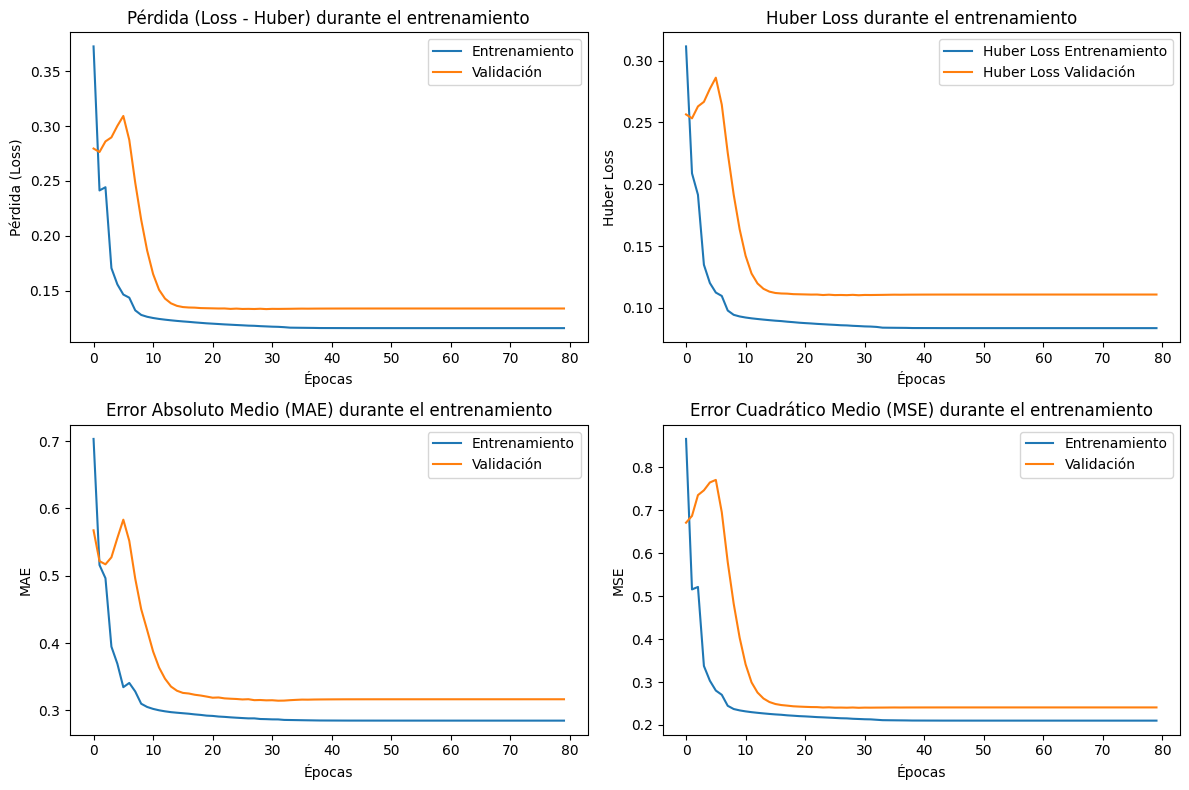

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


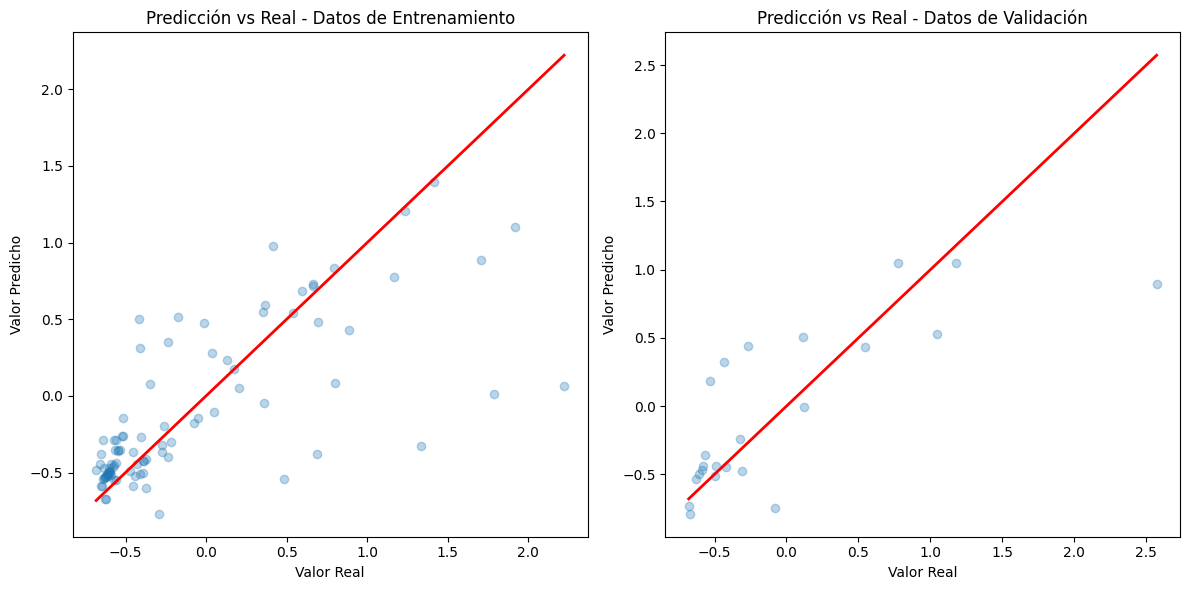


Métricas de entrenamiento:
MSE: 0.21562354797957353
RMSE: 0.46435282703949754
MAE: 0.2723571902504157
R^2: 0.5363559617545205
Correlación de Pearson: -3.5338180426470636e-17
Correlación de Spearman: 0.7482304346483168
SSE: 6065.066341783966
SAE: 5163.137569473999
Media del error: 0.02751563569693363
Desviación estándar del error: 0.8460585086838772
Huber Loss (Entrenamiento): 0.08358319103717804

Métricas de validación:
MSE: 0.2400755640813539
RMSE: 0.48997506475468106
MAE: 0.31486524490819734
R^2: 0.606380388611987
Correlación de Pearson: -5.3280011625904705e-17
Correlación de Spearman: 0.7786561264822135
SSE: 500.62464228857743
SAE: 377.08861202025065
Media del error: -0.0021851295550765083
Desviación estándar del error: 0.9728081042049836
Huber Loss (Validación): 0.11075758934020996
El punto de convergencia (mejor epoch): 30


In [9]:
# Graficar las curvas de aprendizaje (entrenamiento y validación)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss - Huber) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['huber_loss'], label='Huber Loss Entrenamiento')
plt.plot(history.history['val_huber_loss'], label='Huber Loss Validación')
plt.title('Huber Loss durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Huber Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Validación')
plt.title('Error Absoluto Medio (MAE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history.history['mse'], label='Entrenamiento')
plt.plot(history.history['val_mse'], label='Validación')
plt.title('Error Cuadrático Medio (MSE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar los datos entrenados vs reales y validados vs reales
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

plt.figure(figsize=(12, 6))

# Gráfico de datos de entrenamiento
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r', lw=2)
plt.title('Predicción vs Real - Datos de Entrenamiento')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

# Gráfico de datos de validación
plt.subplot(1, 2, 2)
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r', lw=2)
plt.title('Predicción vs Real - Datos de Validación')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

plt.tight_layout()
plt.show()

# Función para calcular la media y desviación estándar
def calcular_media_desviacion(y_true, y_pred):
    diferencia = y_true - y_pred
    media = np.mean(diferencia)
    desviacion = np.std(diferencia)
    return media, desviacion

# Evaluar el modelo final en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)
pearson_train = pearson_correlation(y_train, y_train_pred).numpy()
spearman_train, _ = spearmanr(y_train, y_train_pred)  # Correlación de Spearman
sse_train = np.sum((y_train - y_train_pred) ** 2)
sae_train = np.sum(np.abs(y_train - y_train_pred))
media_train, desviacion_train = calcular_media_desviacion(y_train, y_train_pred)
huber_loss_train = history.history['huber_loss'][-1]

print("\nMétricas de entrenamiento:")
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"MAE: {mae_train}")
print(f"R^2: {r2_train}")
print(f"Correlación de Pearson: {pearson_train}")
print(f"Correlación de Spearman: {spearman_train}")
print(f"SSE: {sse_train}")
print(f"SAE: {sae_train}")
print(f"Media del error: {media_train}")
print(f"Desviación estándar del error: {desviacion_train}")
print(f"Huber Loss (Entrenamiento): {huber_loss_train}")

# Evaluar el modelo final en el conjunto de validación
mse_val = mean_squared_error(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_val_pred)
pearson_val = pearson_correlation(y_val, y_val_pred).numpy()
spearman_val, _ = spearmanr(y_val, y_val_pred)  # Correlación de Spearman
sse_val = np.sum((y_val - y_val_pred) ** 2)
sae_val = np.sum(np.abs(y_val - y_val_pred))
media_val, desviacion_val = calcular_media_desviacion(y_val, y_val_pred)
huber_loss_val = history.history['val_huber_loss'][-1]

print("\nMétricas de validación:")
print(f"MSE: {mse_val}")
print(f"RMSE: {rmse_val}")
print(f"MAE: {mae_val}")
print(f"R^2: {r2_val}")
print(f"Correlación de Pearson: {pearson_val}")
print(f"Correlación de Spearman: {spearman_val}")
print(f"SSE: {sse_val}")
print(f"SAE: {sae_val}")
print(f"Media del error: {media_val}")
print(f"Desviación estándar del error: {desviacion_val}")
print(f"Huber Loss (Validación): {huber_loss_val}")

# Imprimir la época en la que se alcanzó la mejor validación
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"El punto de convergencia (mejor epoch): {best_epoch}")

In [10]:
print("\nMétricas de entrenamiento:")
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"MAE: {mae_train}")
print(f"R^2: {r2_train}")
print(f"Correlación de Pearson: {pearson_train}")
print(f"Correlación de Spearman: {spearman_train}")
print(f"SSE: {sse_train}")
print(f"SAE: {sae_train}")
print(f"Media del error: {media_train}")
print(f"Desviación estándar del error: {desviacion_train}")
print(f"Huber Loss (Entrenamiento): {huber_loss_train}")

print("\nMétricas de validación:")
print(f"MSE: {mse_val}")
print(f"RMSE: {rmse_val}")
print(f"MAE: {mae_val}")
print(f"R^2: {r2_val}")
print(f"Correlación de Pearson: {pearson_val}")
print(f"Correlación de Spearman: {spearman_val}")
print(f"SSE: {sse_val}")
print(f"SAE: {sae_val}")
print(f"Media del error: {media_val}")
print(f"Desviación estándar del error: {desviacion_val}")
print(f"Huber Loss (Validación): {huber_loss_val}")


Métricas de entrenamiento:
MSE: 0.21562354797957353
RMSE: 0.46435282703949754
MAE: 0.2723571902504157
R^2: 0.5363559617545205
Correlación de Pearson: -3.5338180426470636e-17
Correlación de Spearman: 0.7482304346483168
SSE: 6065.066341783966
SAE: 5163.137569473999
Media del error: 0.02751563569693363
Desviación estándar del error: 0.8460585086838772
Huber Loss (Entrenamiento): 0.08358319103717804

Métricas de validación:
MSE: 0.2400755640813539
RMSE: 0.48997506475468106
MAE: 0.31486524490819734
R^2: 0.606380388611987
Correlación de Pearson: -5.3280011625904705e-17
Correlación de Spearman: 0.7786561264822135
SSE: 500.62464228857743
SAE: 377.08861202025065
Media del error: -0.0021851295550765083
Desviación estándar del error: 0.9728081042049836
Huber Loss (Validación): 0.11075758934020996


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


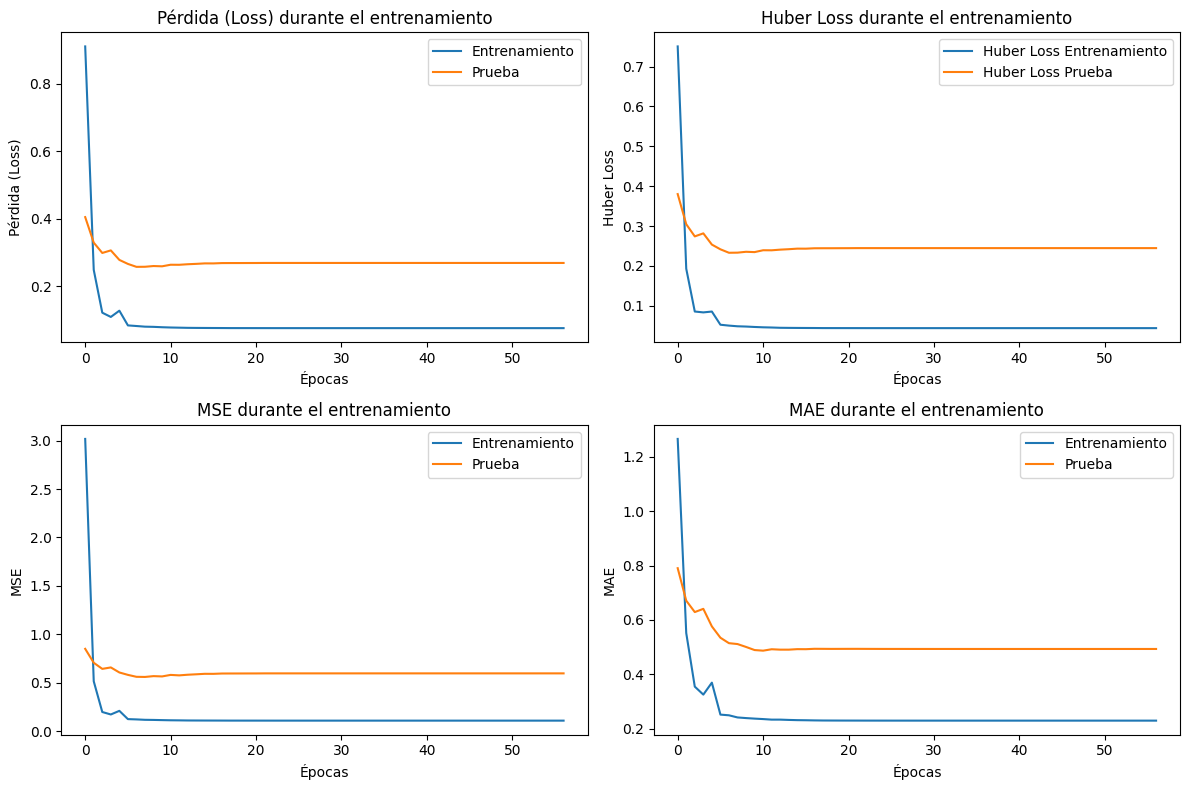

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


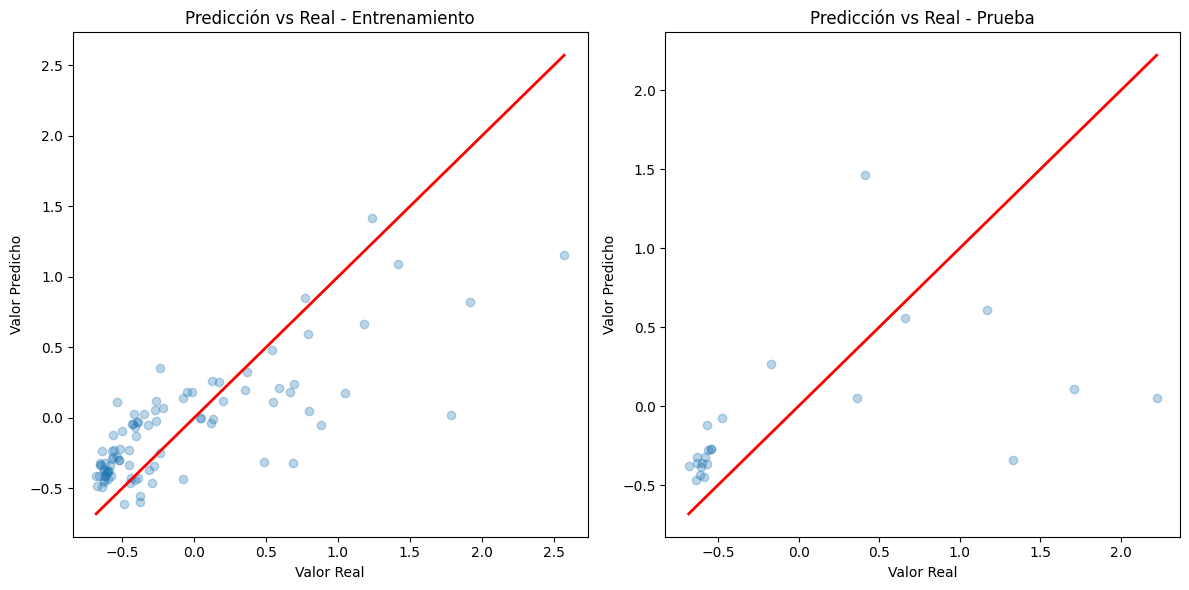

Simulación de cross_val_score (MSE): 0.26452099820772823 ± 0.15732856392876673
Simulación de cross_val_score (RMSE): 0.49478045970520357 ± 0.14040404161431955
Simulación de cross_val_score (MAE): 0.3341944069681004 ± 0.09411676604198453
SSE promedio: 390.537936684161
SAE promedio: 331.8639814721656
R^2 promedio: 0.46198776310250694, Desviación estándar: 0.20251532449709284
Correlación de Pearson promedio: 6.4666598326738004e-18, Desviación estándar: 1.6369536803918394e-16
Correlación de Spearman promedio: 0.6980872554195745, Desviación estándar: 0.06385027724949595
Huber Loss promedio: 0.07557058855891227, Desviación estándar: 0.0202651618047951
El punto de convergencia (mejor epoch): 7


In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
import numpy as np

# Definir el número de pliegues (k) para la validación cruzada
k = 5

# Crear un objeto KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Inicializar listas para almacenar las métricas en cada pliegue
mse_scores = []
mae_scores = []
sse_scores = []
sae_scores = []
r2_scores = []
pearson_scores = []
rmse_scores = []
spearman_scores = []
huber_loss_scores = []

# Iterar sobre los pliegues
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Crear y entrenar el modelo con los datos del pliegue actual
    model = Sequential([
        Dense(int(best_params['units_1']), input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.001)), # Access units_1 from best_params
        LeakyReLU(alpha=0.1),  # Cambiar ELU por LeakyReLU
        BatchNormalization(momentum=0.8),

        Dense(int(best_params['units_2']), kernel_regularizer=tf.keras.regularizers.l2(0.001)), # Access units_2 from best_params
        LeakyReLU(alpha=0.1),  # Cambiar ELU por LeakyReLU
        BatchNormalization(momentum=0.8),

        Dense(1, activation='linear')
    ])

    # Función personalizada para calcular SSE
    def sse(y_true, y_pred):
        return tf.reduce_sum(tf.square(y_true - y_pred))

    # Función personalizada para calcular SAE
    def sae(y_true, y_pred):
        return tf.reduce_sum(tf.abs(y_true - y_pred))

    # Función personalizada para calcular el coeficiente de determinación R^2
    def r2_keras(y_true, y_pred):
        ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
        ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
        return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

    # Función personalizada para calcular el coeficiente de correlación de Pearson
    def pearson_correlation(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float64)  # Cast y_true to float64
        y_pred = tf.cast(y_pred, tf.float64)  # Cast y_pred to float64
        x = y_true - tf.reduce_mean(y_true)
        y = y_pred - tf.reduce_mean(y_pred)
        r_num = tf.reduce_sum(x * y)
        r_den = tf.sqrt(tf.reduce_sum(tf.square(x)) * tf.reduce_sum(tf.square(y)))
        return r_num / (r_den + tf.keras.backend.epsilon())

    model.compile(optimizer=Adagrad(best_params['learning_rate']),#------------------------------------
                  loss=tf.keras.losses.Huber(),                      #---------------------
                  metrics=['mae', 'mse', sse, sae, r2_keras, pearson_correlation, tf.keras.losses.Huber(name='huber_loss')])

    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True) #-----------------------50
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=1000, #--------------------------1000
                        batch_size=64,
                        callbacks=[early_stopping, reduce_lr],
                        verbose=0)

    # Predecir con el modelo en el conjunto de validación
    y_pred = model.predict(X_val)

    # Calcular las métricas de error
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    sse = np.sum((y_val - y_pred) ** 2)
    sae = np.sum(np.abs(y_val - y_pred))
    r2 = r2_score(y_val, y_pred)
    pearson = pearson_correlation(y_val, y_pred).numpy()
    spearman, _ = spearmanr(y_val, y_pred)
    huber_loss = history.history['huber_loss'][-1]

    # Almacenar las métricas en las listas
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    sse_scores.append(sse)
    sae_scores.append(sae)
    r2_scores.append(r2)
    pearson_scores.append(pearson)
    spearman_scores.append(spearman)
    huber_loss_scores.append(huber_loss)

import matplotlib.pyplot as plt

# Graficar las curvas de aprendizaje (pérdida, huber_loss, mse, mae)
plt.figure(figsize=(12, 8))

# Pérdida (Loss)
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Prueba')
plt.title('Pérdida (Loss) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()

# Huber Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['huber_loss'], label='Huber Loss Entrenamiento')
plt.plot(history.history['val_huber_loss'], label='Huber Loss Prueba')
plt.title('Huber Loss durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Huber Loss')
plt.legend()

# MSE
plt.subplot(2, 2, 3)
plt.plot(history.history['mse'], label='Entrenamiento')
plt.plot(history.history['val_mse'], label='Prueba')
plt.title('MSE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

# MAE
plt.subplot(2, 2, 4)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Prueba')
plt.title('MAE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Gráfico de predicciones en los datos de entrenamiento
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r', lw=2)
plt.title('Predicción vs Real - Entrenamiento')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

plt.subplot(1, 2, 2)
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r', lw=2)
plt.title('Predicción vs Real - Prueba')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

plt.tight_layout()
plt.show()

# Calcular estadísticas de las métricas
mse_mean = np.mean(mse_scores)
mse_std = np.std(mse_scores)
rmse_mean = np.mean(rmse_scores)
rmse_std = np.std(rmse_scores)
mae_mean = np.mean(mae_scores)
mae_std = np.std(mae_scores)
sse_mean = np.mean(sse_scores)
sae_mean = np.mean(sae_scores)
r2_mean = np.mean(r2_scores)
r2_std = np.std(r2_scores)
pearson_mean = np.mean(pearson_scores)
pearson_std = np.std(pearson_scores)
spearman_mean = np.mean(spearman_scores)
spearman_std = np.std(spearman_scores)
huber_loss_mean = np.mean(huber_loss_scores)
huber_loss_std = np.std(huber_loss_scores)

# Simular cross_val_score al imprimir el promedio de las métricas
print(f"Simulación de cross_val_score (MSE): {mse_mean} ± {mse_std}")
print(f"Simulación de cross_val_score (RMSE): {rmse_mean} ± {rmse_std}")
print(f"Simulación de cross_val_score (MAE): {mae_mean} ± {mae_std}")
print(f"SSE promedio: {sse_mean}")
print(f"SAE promedio: {sae_mean}")
print(f"R^2 promedio: {r2_mean}, Desviación estándar: {r2_std}")
print(f"Correlación de Pearson promedio: {pearson_mean}, Desviación estándar: {pearson_std}")
print(f"Correlación de Spearman promedio: {spearman_mean}, Desviación estándar: {spearman_std}")
print(f"Huber Loss promedio: {huber_loss_mean}, Desviación estándar: {huber_loss_std}")

# Imprimir la época en la que se alcanzó la mejor validación
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"El punto de convergencia (mejor epoch): {best_epoch}")